In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import BaggingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import VotingClassifier
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from IPython.display import clear_output
from tqdm import tqdm

## 기본전처리

In [2]:
train = pd.read_csv("./data/train.csv", encoding="utf-8-sig")
test = pd.read_csv("./data/test.csv", encoding="utf-8-sig")
sample = pd.read_csv("./data/sample_submission.csv", encoding="utf-8-sig")


train.describe()

train.info()
#plt.figure(figsize=(20, 20))
#sns.heatmap(train[train.select_dtypes(exclude='object').columns].corr(), annot=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            10000 non-null  object 
 1   subscription_duration              10000 non-null  int64  
 2   recent_login_time                  10000 non-null  int64  
 3   average_login_time                 10000 non-null  float64
 4   average_time_per_learning_session  10000 non-null  float64
 5   monthly_active_learning_days       10000 non-null  int64  
 6   total_completed_courses            10000 non-null  int64  
 7   recent_learning_achievement        10000 non-null  float64
 8   abandoned_learning_sessions        10000 non-null  int64  
 9   community_engagement_level         10000 non-null  int64  
 10  preferred_difficulty_level         10000 non-null  object 
 11  subscription_type                  10000 non-null  obje

In [31]:
train.head()

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1


In [15]:
# train['Abandon_compare_complete'] = train['abandoned_learning_sessions']/train['total_completed_courses']
# test['Abandon_compare_complete'] = test['abandoned_learning_sessions']/test['total_completed_courses']

# 수치형 및 범주형 변수 구분
train.drop('abandoned_learning_sessions', axis=1, inplace=True)
test.drop('abandoned_learning_sessions', axis=1, inplace=True)
train.drop('average_login_time', axis=1, inplace=True)
test.drop('average_login_time', axis=1, inplace=True)
train.drop('payment_pattern', axis=1, inplace=True)
test.drop('payment_pattern', axis=1, inplace=True)
train['recent_learning_achievement'] = train['recent_learning_achievement'].apply(lambda x : train['recent_learning_achievement'].mean() if x >= 100 else x)

numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64'] and col not in ['target']]
#numerical_cols.remove('payment_pattern')
categorical_cols = [col for col in train.columns if train[col].dtype == 'object' and col not in ['user_id']]
#categorical_cols.append('payment_pattern')
# 데이터 스케일링을 위한 StandardScaler 인스턴스 생성
scaler = StandardScaler()

# 수치형 데이터에 대해 스케일링 적용
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

# 레이블 인코딩을 위한 LabelEncoder 인스턴스 생성 및 적용
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    train[col] = label_encoders[col].fit_transform(train[col])
    test[col] = label_encoders[col].transform(test[col])

# 전처리 후 학습 데이터 확인
train.head()

# 특성과 타겟 변수 분리
X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
y = train['target']

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder, RobustScaler

# 수치형 및 범주형 변수 구분
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64'] and col not in ['target']]
numerical_cols.remove('payment_pattern')
categorical_cols = [col for col in train.columns if train[col].dtype == 'object' and col not in ['user_id']]
categorical_cols.append('payment_pattern')
# 데이터 스케일링을 위한 StandardScaler 인스턴스 생성
scaler = StandardScaler()

# 수치형 데이터에 대해 스케일링 적용
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

# 레이블 인코딩을 위한 LabelEncoder 인스턴스 생성 및 적용
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    train[col] = label_encoders[col].fit_transform(train[col])
    test[col] = label_encoders[col].transform(test[col])



# 전처리 후 학습 데이터 확인
train.head()

# 특성과 타겟 변수 분리
X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
y = train['target']

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
train.describe()

,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
count,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.008550,0.000943,3.740467e-03,2.875078e-01,-0.037883,0.045500,-7.183160e-03,0.021800,-0.056950,1.100800,0.402100,0.005250,3.502900,0.619900
std,0.550075,0.597327,7.561871e-01,9.289761e-01,0.577687,0.726825,7.416552e-01,0.877526,0.631088,0.700492,0.490346,0.710491,2.311261,0.485435
min,-0.916667,-1.000000,-3.177293e+00,-6.229283e-01,-1.000000,-2.200000,-2.915299e+00,-1.500000,-1.500000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,-0.500000,-0.500000,-4.921302e-01,-3.698076e-01,-0.500000,-0.400000,-5.094894e-01,-0.500000,-0.500000,1.000000,0.000000,-0.500000,1.000000,0.000000
50%,0.000000,0.000000,2.237370e-16,-5.889928e-17,0.000000,0.000000,5.286434e-16,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000,1.000000
75%,0.500000,0.500000,5.078698e-01,6.301924e-01,0.500000,0.600000,4.905106e-01,0.500000,0.500000,2.000000,1.000000,0.500000,6.000000,1.000000
max,0.916667,1.000000,3.027718e+00,7.723635e+00,0.916667,3.000000,2.791309e+00,4.500000,0.500000,2.000000,1.000000,4.000000,7.000000,1.000000


In [5]:
X_train.head()

,subscription_duration,recent_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history
9254,-0.135958,-1.436615,-0.345056,-0.511462,0.762945,-1.374810,0.882568,1,0,-0.711163
1561,0.318548,0.476767,2.338099,-0.078680,0.487762,1.159508,0.882568,1,0,-1.414937
1670,0.167046,1.433458,-0.946320,0.209842,0.762945,-1.050296,0.090246,1,1,-1.414937
6087,1.076059,-1.077856,0.613642,-0.799984,-0.612970,0.126036,0.090246,1,1,-0.711163
6669,1.227561,-1.436615,0.393265,0.209842,-0.888154,0.712627,0.090246,2,1,-1.414937


In [53]:
# train[train['recent_learning_achievement']> 100][['recent_learning_achievement', 'target']]

,recent_learning_achievement,target
37,104.157237,0
243,103.630210,1
328,100.135640,1
333,103.049387,0
547,105.318001,1
687,101.023020,1
791,101.160898,1
890,101.766371,1
905,101.905012,1
1149,102.324982,0


In [48]:
import numpy as np

qu25 = np.quantile(train['average_time_per_learning_session'], 0.25)
qu75 = np.quantile(train['average_time_per_learning_session'], 0.75)

qu75 + (qu75-qu25)*1.5

166.04558435741137

In [7]:
# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

# Drop 3개적용한 모델 가중치 조합

In [16]:
weights_to_test = [(w1 * 0.1, w2 * 0.1, w3 * 0.1) for w1 in range(1, 10) for w2 in range(1, 10) for w3 in range(1, 10) if w1 + w2 + w3 == 10]
weights_to_test

[(0.1, 0.1, 0.8),
 (0.1, 0.2, 0.7000000000000001),
 (0.1, 0.30000000000000004, 0.6000000000000001),
 (0.1, 0.4, 0.5),
 (0.1, 0.5, 0.4),
 (0.1, 0.6000000000000001, 0.30000000000000004),
 (0.1, 0.7000000000000001, 0.2),
 (0.1, 0.8, 0.1),
 (0.2, 0.1, 0.7000000000000001),
 (0.2, 0.2, 0.6000000000000001),
 (0.2, 0.30000000000000004, 0.5),
 (0.2, 0.4, 0.4),
 (0.2, 0.5, 0.30000000000000004),
 (0.2, 0.6000000000000001, 0.2),
 (0.2, 0.7000000000000001, 0.1),
 (0.30000000000000004, 0.1, 0.6000000000000001),
 (0.30000000000000004, 0.2, 0.5),
 (0.30000000000000004, 0.30000000000000004, 0.4),
 (0.30000000000000004, 0.4, 0.30000000000000004),
 (0.30000000000000004, 0.5, 0.2),
 (0.30000000000000004, 0.6000000000000001, 0.1),
 (0.4, 0.1, 0.5),
 (0.4, 0.2, 0.4),
 (0.4, 0.30000000000000004, 0.30000000000000004),
 (0.4, 0.4, 0.2),
 (0.4, 0.5, 0.1),
 (0.5, 0.1, 0.4),
 (0.5, 0.2, 0.30000000000000004),
 (0.5, 0.30000000000000004, 0.2),
 (0.5, 0.4, 0.1),
 (0.6000000000000001, 0.1, 0.30000000000000004),
 (0.6

In [24]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from IPython.display import clear_output
from tqdm import tqdm
#svc = SVC(C=100, gamma=0.01, random_state=42, probability=True)
#mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=70, learning_rate_init=0.001, learning_rate='constant', max_iter=500, solver='sgd', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=500, random_state=42, subsample=0.5)
cat = CatBoostClassifier(depth=6, iterations=300, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)

max_val = 0
for weight in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [('cat', cat),
                                ('mp', mp),
                                ('xgb', xgb)],
                                voting='soft',
                                weights=weight

                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {weight}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight


100%|██████████| 36/36 [02:43<00:00,  4.54s/it]

max_weigth : (0.8, 0.1, 0.1), max_val : 0.5015926670223676
              precision    recall  f1-score   support

           0       0.38      0.38      0.38       758
           1       0.62      0.63      0.62      1242

    accuracy                           0.53      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.53      0.53      2000



In [29]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from IPython.display import clear_output
from tqdm import tqdm

weights_to_test = [(w1 * 0.1, w2 * 0.1) for w1 in range(1, 10) for w2 in range(1, 10) if w1 + w2 == 10]
weights_to_test

#svc = SVC(C=100, gamma=0.01, random_state=42, probability=True)
#mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=70, learning_rate_init=0.001, learning_rate='constant', max_iter=500, solver='sgd', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=500, random_state=42, subsample=0.5)
cat = CatBoostClassifier(depth=6, iterations=300, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)

max_val = 0
for weight in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [('cat', cat),
                                #('mp', mp),
                                ('xgb', xgb)],
                                voting='soft',
                                weights=weight

                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {weight}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight


100%|██████████| 9/9 [00:23<00:00,  2.60s/it]

max_weigth : (0.9, 0.1), max_val : 0.5012418246435946
              precision    recall  f1-score   support

           0       0.38      0.43      0.40       758
           1       0.62      0.58      0.60      1242

    accuracy                           0.52      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.52      0.52      2000



In [30]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from IPython.display import clear_output
from tqdm import tqdm

weights_to_test = [(w1 * 0.1, w2 * 0.1) for w1 in range(1, 10) for w2 in range(1, 10) if w1 + w2 == 10]
weights_to_test

#svc = SVC(C=100, gamma=0.01, random_state=42, probability=True)
#mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=70, learning_rate_init=0.001, learning_rate='constant', max_iter=500, solver='sgd', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=500, random_state=42, subsample=0.5)
cat = CatBoostClassifier(depth=6, iterations=300, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)

max_val = 0
for weight in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [#('cat', cat),
                                ('mp', mp),
                                ('xgb', xgb)],
                                voting='soft',
                                weights=weight

                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {weight}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight


 11%|█         | 1/9 [00:03<00:24,  3.05s/it]

max_weigth : (0.1, 0.9), max_val : 0.49772794493291383
              precision    recall  f1-score   support

           0       0.38      0.35      0.36       758
           1       0.62      0.64      0.63      1242

    accuracy                           0.53      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.53      0.53      2000



100%|██████████| 9/9 [00:27<00:00,  3.02s/it]


In [31]:


weights_to_test = [(w1 * 0.1, w2 * 0.1) for w1 in range(1, 10) for w2 in range(1, 10) if w1 + w2 == 10]
weights_to_test

#svc = SVC(C=100, gamma=0.01, random_state=42, probability=True)
#mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=70, learning_rate_init=0.001, learning_rate='constant', max_iter=500, solver='sgd', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=500, random_state=42, subsample=0.5)
cat = CatBoostClassifier(depth=6, iterations=300, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)

max_val = 0
for weight in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [('cat', cat),
                                ('mp', mp)],
                                #('xgb', xgb)],
                                voting='soft',
                                weights=weight

                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {weight}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight


 89%|████████▉ | 8/9 [00:28<00:03,  3.55s/it]

max_weigth : (0.8, 0.2), max_val : 0.5021152073288642
              precision    recall  f1-score   support

           0       0.38      0.37      0.37       758
           1       0.62      0.64      0.63      1242

    accuracy                           0.54      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.54      0.53      2000



100%|██████████| 9/9 [00:31<00:00,  3.54s/it]


# Drop 안한거 가중치 조합 테스트

In [9]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier
## standard scaler
weights_to_test = [(w1 * 0.1, w2 * 0.1, w3 * 0.1) for w1 in range(1, 10) for w2 in range(1, 10) for w3 in range(1, 10) if w1 + w2 + w3 == 10]
weights_to_test

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

svc = SVC(C=100, gamma=0.01, random_state=42, probability=True, class_weight=weights)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)
max_val = 0

for weight in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [('svc', svc),
                                ('mp', mp),
                                ('xgb', xgb)],
                                voting='soft',
                                weights=weight

                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {weight}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight

 22%|██▏       | 8/36 [04:07<14:25, 30.92s/it]

max_weigth : (0.1, 0.8, 0.1), max_val : 0.5133204956370679
              precision    recall  f1-score   support

           0       0.40      0.33      0.36       758
           1       0.63      0.70      0.67      1242

    accuracy                           0.56      2000
   macro avg       0.52      0.52      0.51      2000
weighted avg       0.54      0.56      0.55      2000



100%|██████████| 36/36 [18:49<00:00, 31.37s/it]


In [11]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier
## minmax scaler
weights_to_test = [(w1 * 0.1, w2 * 0.1, w3 * 0.1) for w1 in range(1, 10) for w2 in range(1, 10) for w3 in range(1, 10) if w1 + w2 + w3 == 10]
weights_to_test

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

svc = SVC(C=100, gamma=0.01, random_state=42, probability=True, class_weight=weights)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)
max_val = 0

for weight in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [('svc', svc),
                                ('mp', mp),
                                ('xgb', xgb)],
                                voting='soft',
                                weights=weight

                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {weight}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight

  6%|▌         | 2/36 [00:50<14:17, 25.22s/it]

max_weigth : (0.1, 0.2, 0.7000000000000001), max_val : 0.5025363110806268
              precision    recall  f1-score   support

           0       0.38      0.36      0.37       758
           1       0.62      0.65      0.64      1242

    accuracy                           0.54      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.54      0.53      2000



100%|██████████| 36/36 [14:59<00:00, 24.97s/it]


In [22]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier

weights_to_test = [(w1 * 0.5, w2 * 0.5) for w1 in range(1, 20) for w2 in range(1, 20) if w1 + w2 == 20]
weights_to_test


# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

#svc = SVC(C=100, gamma=0.01, random_state=42, probability=True, class_weight=weights)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)
max_val = 0

for weight in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [#('svc', svc),
                                ('mp', mp),
                                ('xgb', xgb)],
                                voting='soft',
                                weights=weight

                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {weight}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight
# min : 0.5016342043444918
# sta : 0.5168004757656854
#  (0.9, 0.1), max_val : 0.5168004757656854

100%|██████████| 19/19 [01:47<00:00,  5.64s/it]

max_weigth : (9.5, 0.5), max_val : 0.5195075306695726
              precision    recall  f1-score   support

           0       0.41      0.36      0.38       758
           1       0.64      0.68      0.66      1242

    accuracy                           0.56      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.55      0.56      0.55      2000



In [20]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier

weights_to_test = [(w1 * 0.1, w2 * 0.1) for w1 in range(1, 10) for w2 in range(1, 10) if w1 + w2 == 10]
weights_to_test

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

svc = SVC(C=100, gamma=0.01, random_state=42, probability=True, class_weight=weights)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)
max_val = 0

for weight in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [('svc', svc),
                                #('mp', mp),
                                ('xgb', xgb)],
                                voting='soft',
                                weights=weight

                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {weight}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight

# min : 0.5022550341101697
# sta : 0.5028545248361532


 44%|████▍     | 4/9 [01:24<01:45, 21.08s/it]

max_weigth : (0.4, 0.6000000000000001), max_val : 0.5028545248361532
              precision    recall  f1-score   support

           0       0.38      0.35      0.37       758
           1       0.62      0.66      0.64      1242

    accuracy                           0.54      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.54      0.54      2000



100%|██████████| 9/9 [03:09<00:00, 21.03s/it]


In [14]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier
## minmax scaler
weights_to_test = [(w1 * 0.1, w2 * 0.1) for w1 in range(1, 10) for w2 in range(1, 10) if w1 + w2 == 10]
weights_to_test

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

svc = SVC(C=100, gamma=0.01, random_state=42, probability=True, class_weight=weights)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)
max_val = 0

for weight in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [('svc', svc),
                                ('mp', mp)],
                                #('xgb', xgb)],
                                voting='soft',
                                weights=weight

                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {weight}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight

# min : 0.3943883380974001
# sta

 11%|█         | 1/9 [00:20<02:44, 20.51s/it]

max_weigth : (0.1, 0.9), max_val : 0.3943883380974001
              precision    recall  f1-score   support

           0       0.31      0.02      0.03       758
           1       0.62      0.98      0.76      1242

    accuracy                           0.61      2000
   macro avg       0.46      0.50      0.39      2000
weighted avg       0.50      0.61      0.48      2000



100%|██████████| 9/9 [03:04<00:00, 20.45s/it]


# Drop 안한거 svc -> cat

In [21]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier
## standard scaler
weights_to_test = [(w1 * 0.1, w2 * 0.1, w3 * 0.1) for w1 in range(1, 10) for w2 in range(1, 10) for w3 in range(1, 10) if w1 + w2 + w3 == 10]
weights_to_test

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

cat = CatBoostClassifier(depth=6, iterations=700, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)
max_val = 0

for weight in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [('cat', cat),
                                ('mp', mp),
                                ('xgb', xgb)],
                                voting='soft',
                                weights=weight

                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {weight}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight

 22%|██▏       | 8/36 [01:05<03:46,  8.09s/it]

max_weigth : (0.1, 0.8, 0.1), max_val : 0.514068324623177
              precision    recall  f1-score   support

           0       0.40      0.34      0.37       758
           1       0.63      0.69      0.66      1242

    accuracy                           0.56      2000
   macro avg       0.52      0.52      0.51      2000
weighted avg       0.54      0.56      0.55      2000



100%|██████████| 36/36 [04:46<00:00,  7.96s/it]


In [23]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier

weights_to_test = [(w1 * 0.5, w2 * 0.5) for w1 in range(1, 20) for w2 in range(1, 20) if w1 + w2 == 20]
weights_to_test

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

cat = CatBoostClassifier(depth=6, iterations=700, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)
max_val = 0

for weight in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [('cat', cat),
                                ('mp', mp)],
                                #('xgb', xgb)],
                                voting='soft',
                                weights=[0.2, 0.8]

                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {weight}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight
# max_weigth : (0.2, 0.8), max_val : 0.5211014666267584
#  0       0.41      0.36      0.38       758
#  1       0.64      0.68      0.66      1242

  5%|▌         | 1/19 [00:08<02:33,  8.51s/it]

max_weigth : (0.5, 9.5), max_val : 0.5211014666267584
              precision    recall  f1-score   support

           0       0.41      0.36      0.38       758
           1       0.64      0.68      0.66      1242

    accuracy                           0.56      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.55      0.56      0.55      2000



100%|██████████| 19/19 [02:43<00:00,  8.61s/it]


In [23]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier

weights_to_test = [(w1 * 0.1, w2 * 0.1) for w1 in range(1, 10) for w2 in range(1, 10) if w1 + w2 == 10]
weights_to_test

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

cat = CatBoostClassifier(depth=6, iterations=700, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)
max_val = 0

for weight in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [('cat', cat),
                                #('mp', mp)],
                                ('xgb', xgb)],
                                voting='soft',
                                weights=weight

                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {weight}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight
# min : 0.5016342043444918
# sta : 0.5168004757656854

 44%|████▍     | 4/9 [00:10<00:13,  2.71s/it]

max_weigth : (0.4, 0.6000000000000001), max_val : 0.5025363110806268
              precision    recall  f1-score   support

           0       0.38      0.36      0.37       758
           1       0.62      0.65      0.64      1242

    accuracy                           0.54      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.54      0.53      2000



100%|██████████| 9/9 [00:24<00:00,  2.69s/it]


In [12]:
# 테스트 데이터에 대한 예측 수행
test_X = test.drop(columns=['user_id'])  # user_id는 제외하고 특성 데이터로 사용
test_predictions = voting_model.predict(test_X)

# 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
sample['target'] = test_predictions
submit_path = f'./voting_model/voting(cat, xgb)2_tuned_model_drop(aban, ave, pay)_classweight.csv'
sample.to_csv(submit_path, index=False)


In [222]:
for i ,j in zip(X_train.columns, voting_model.feature_importances_):
    print(i,j)

subscription_duration 0.10698203
recent_login_time 0.10118902
average_time_per_learning_session 0.10923754
monthly_active_learning_days 0.099171825
total_completed_courses 0.09464165
recent_learning_achievement 0.10586606
community_engagement_level 0.10021998
preferred_difficulty_level 0.100718796
subscription_type 0.08933906
customer_inquiry_history 0.092634104


## 제출용

In [52]:
# 현재 최대 점수 !!! 0.5330428221
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier

train = pd.read_csv("./data/train.csv", encoding="utf-8-sig")
test = pd.read_csv("./data/test.csv", encoding="utf-8-sig")
sample = pd.read_csv("./data/sample_submission.csv", encoding="utf-8-sig")

# train['recent_learning_achievement'] = train['recent_learning_achievement'].apply(lambda x :  train['recent_learning_achievement'].mean() if x  > 100 else x)
train['payment_pattern'] = train['recent_learning_achievement'].apply(lambda x: 'continuous' if x in [7, 5, 3, 1] else ('discontinuous' if x in [6, 4, 2] else 'Never'))
test['payment_pattern'] = test['recent_learning_achievement'].apply(lambda x: 'continuous' if x in [7, 5, 3, 1] else ('discontinuous' if x in [6, 4, 2] else 'Never'))

# test['recent_learning_achievement'] = test['recent_learning_achievement'].apply(lambda x :  train['recent_learning_achievement'].mean() if x  > 100 else x)
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder

# 수치형 및 범주형 변수 구분
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64'] and col not in ['target']]
#numerical_cols.remove('payment_pattern')
categorical_cols = [col for col in train.columns if train[col].dtype == 'object' and col not in ['user_id']]
#categorical_cols.append('payment_pattern')
# 데이터 스케일링을 위한 StandardScaler 인스턴스 생성
scaler = StandardScaler()

# 수치형 데이터에 대해 스케일링 적용
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

# 레이블 인코딩을 위한 LabelEncoder 인스턴스 생성 및 적용
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    train[col] = label_encoders[col].fit_transform(train[col])
    test[col] = label_encoders[col].transform(test[col])

# 전처리 후 학습 데이터 확인
train.head()

# 특성과 타겟 변수 분리
X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
y = train['target']

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

cat = CatBoostClassifier(depth=6, iterations=700, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)
max_val = 0


voting_model = VotingClassifier(estimators=
                            [('cat', cat),
                            ('mp', mp)],
                            #('xgb', xgb)],
                            voting='soft',
                            weights=[0.2, 0.8]

                            
                            )

voting_model.fit(X_train, y_train)

# 검증 데이터에서 성능 평가
val_predictions = voting_model.predict(X_val)
val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

print(f'max_val : {val_f1}')
print(classification_report(y_val, val_predictions, zero_division=0))

test.drop(columns=['user_id'], inplace=True, axis=1) 
test_predictions = voting_model.predict(test)

# 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
sample['target'] = test_predictions

# 리더보드 제출을 위해 나의 예측 결과를 baseline_submit.csv로 저장
#submit_path = './voting(cat, mp)_drop(None)_nopreprocessing).csv'
#sample.to_csv(submit_path, index=False)

sample.head()

max_val : 0.49441982967414
              precision    recall  f1-score   support

           0       0.38      0.27      0.32       758
           1       0.62      0.73      0.67      1242

    accuracy                           0.56      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.53      0.56      0.54      2000



,user_id,target
0,0001d6e9,0
1,0002c77d,1
2,0002df5b,0
3,000b6068,1
4,00184a0c,1


In [47]:
train = pd.read_csv("./data/train.csv", encoding="utf-8-sig")
test = pd.read_csv("./data/test.csv", encoding="utf-8-sig")
sample = pd.read_csv("./data/sample_submission.csv", encoding="utf-8-sig")
train[train['target']==0].mode()

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,00030dc2,6.0,27.0,3.636424,0.011515,18.0,12.0,35.941755,3.0,5.0,Low,Basic,1.0,1.0,0.0
1,000a7fac,NaN,NaN,4.735407,0.012562,NaN,NaN,41.752942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001daa99,NaN,NaN,4.903691,0.017473,NaN,NaN,42.254863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0047ee1a,NaN,NaN,5.433492,0.029555,NaN,NaN,43.068185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,007855db,NaN,NaN,5.640182,0.045014,NaN,NaN,43.733914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,ffb25bdf,NaN,NaN,24.481035,174.327012,NaN,NaN,104.812784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3797,ffbed767,NaN,NaN,24.962679,174.562720,NaN,NaN,105.074082,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3798,ffc7a476,NaN,NaN,25.279514,176.084277,NaN,NaN,106.385512,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3799,ffcca840,NaN,NaN,25.815833,177.351455,NaN,NaN,106.942927,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
train[train['target']==1].mode()

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,00058702,4.0,6.0,2.366189,0.013535,24.0,12.0,36.115562,2.0,5.0,Low,Basic,2.0,0.0,1.0
1,00076619,NaN,NaN,3.375170,0.035931,NaN,NaN,36.830979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00109fa1,NaN,NaN,3.483285,0.037657,NaN,NaN,42.430858,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00153d57,NaN,NaN,3.970000,0.058419,NaN,NaN,42.870248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0025c0af,NaN,NaN,4.578543,0.060640,NaN,NaN,42.970217,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6194,ff9a0d6e,NaN,NaN,25.100608,444.324058,NaN,NaN,106.102230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6195,ffb14cb4,NaN,NaN,25.271289,447.095844,NaN,NaN,108.127099,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6196,ffe5da30,NaN,NaN,25.408557,470.289498,NaN,NaN,109.686851,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6197,fff3144f,NaN,NaN,26.125596,490.233443,NaN,NaN,111.219647,NaN,NaN,NaN,NaN,NaN,NaN,NaN


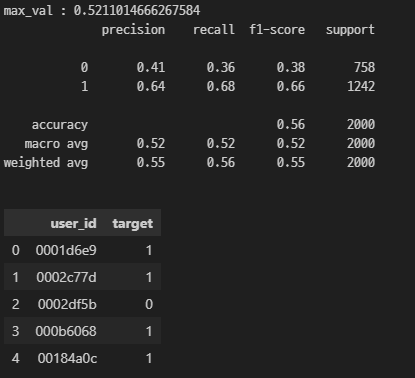

In [61]:
# 현재 최대 점수 !!! 0.5330428221
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier

train = pd.read_csv("./data/train.csv", encoding="utf-8-sig")
test = pd.read_csv("./data/test.csv", encoding="utf-8-sig")
sample = pd.read_csv("./data/sample_submission.csv", encoding="utf-8-sig")


from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder

# 수치형 및 범주형 변수 구분
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64'] and col not in ['target']]
numerical_cols.remove('payment_pattern')
categorical_cols = [col for col in train.columns if train[col].dtype == 'object' and col not in ['user_id']]
categorical_cols.append('payment_pattern')
# 데이터 스케일링을 위한 StandardScaler 인스턴스 생성
scaler = StandardScaler()

# 수치형 데이터에 대해 스케일링 적용
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

# 레이블 인코딩을 위한 LabelEncoder 인스턴스 생성 및 적용
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    train[col] = label_encoders[col].fit_transform(train[col])
    test[col] = label_encoders[col].transform(test[col])

# 전처리 후 학습 데이터 확인
train.head()

# 특성과 타겟 변수 분리
X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
y = train['target']

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

rf = RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_leaf=3, min_samples_split=2, n_estimators=200, random_state=42, class_weight=weights)
gb = GradientBoostingClassifier(learning_rate=1.0, max_depth=4, n_estimators=500, random_state=42, subsample=0.7)
svc = SVC(C=100, gamma=0.01, random_state=42, probability=True, class_weight=weights)
bgg = BaggingClassifier()
hgb = HistGradientBoostingClassifier(l2_regularization=0.1, learning_rate=0.5, max_depth=7, max_iter=300, random_state=42, class_weight=weights, categorical_features=[9, 10, 12])
cat = CatBoostClassifier(depth=6, iterations=700, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5, class_weights=weights)

voting_model = VotingClassifier(estimators=
                            [
                            ('svc', svc),
                            ('cat', cat),
                            ('mp', mp),
                            ('xgb', xgb)],
                            voting='soft',
                            weights=[1, 2, 2, 2]
                      
                            )

voting_model.fit(X_train, y_train)


# 검증 데이터에서 성능 평가
val_predictions = voting_model.predict(X_val)
val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

print(f'max_val : {val_f1}')
print(classification_report(y_val, val_predictions, zero_division=0))

c:\Users\dbswo\anaconda3\envs\subs_predict\lib\site-packages\xgboost\core.py:160: UserWarning: [16:21:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weights" } are not used.

  warnings.warn(smsg, UserWarning)


max_val : 0.490144904856496
              precision    recall  f1-score   support

           0       0.37      0.28      0.32       758
           1       0.62      0.70      0.66      1242

    accuracy                           0.55      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.52      0.55      0.53      2000

